🎯 Using Grad-CAM on layer: conv2d_5

📌 **Prediction Result:**
✅ Condition: Normal (38.51%)

🔍 **Color Meaning in Heatmap:**
🔴 RED   → High Importance (Model focused here)
🟡 YELLOW → Moderate Importance
🔵 BLUE  → Low/No Importance (Ignored)


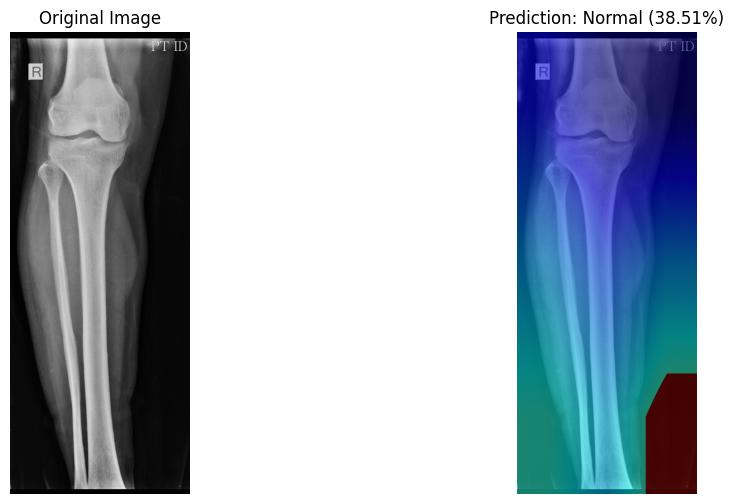

In [20]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy.ndimage import gaussian_filter

# Load trained model
model_path = r"C:\Users\91947\Desktop\mcaproj\models\osteoporosis_resnet50.keras"
model = load_model(model_path)

# Class labels
CLASS_LABELS = ["Normal", "Osteopenia", "Osteoporosis"]

# Find the last convolutional layer
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if "conv" in layer.name:
            return layer.name
    return None

layer_name = find_last_conv_layer(model)
if layer_name is None:
    raise ValueError("❌ No convolutional layer found for Grad-CAM!")

print(f"🎯 Using Grad-CAM on layer: {layer_name}")

# Preprocess Image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Could not load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_resized = np.expand_dims(img_resized, axis=0).astype(np.float32) / 255.0
    return img_resized, img  # Return both resized image and original image

# Compute Grad-CAM
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array, training=False)
        class_idx = np.argmax(predictions[0])  # Most probable class
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = np.sum(conv_output * pooled_grads, axis=-1)  # Weighted sum

    # ✅ Normalize & Apply Gaussian Smoothing
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)  # Avoid division by zero
    heatmap = gaussian_filter(heatmap, sigma=1)  # Smooths heatmap

    return heatmap, class_idx, tf.nn.softmax(predictions[0]).numpy()

# Overlay Grad-CAM **Without Distortion**
def overlay_gradcam(original_image, heatmap, alpha=0.5, threshold=0.4):
    img = original_image.copy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # ✅ Apply threshold to highlight important regions
    heatmap = np.where(heatmap > threshold, heatmap, 0)

    # Normalize before applying color map
    heatmap = np.uint8(255 * (heatmap / np.max(heatmap)))  
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ✅ Fix bottom distortion by using `cv2.addWeighted()` correctly
    heatmap_mask = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)

    return heatmap_mask

# Load & Process Image
image_path = r"C:\Users\91947\Desktop\dap and iot\test\pro\Normal\Normal 18.jpg"
img_array, original_image = preprocess_image(image_path)

# Compute Grad-CAM
heatmap, class_idx, preds = compute_gradcam(model, img_array, layer_name)

# Prediction
predicted_class = CLASS_LABELS[class_idx]
predicted_confidence = preds[class_idx] * 100

# ✅ Print Prediction Info
print("\n📌 **Prediction Result:**")
print(f"✅ Condition: {predicted_class} ({predicted_confidence:.2f}%)")
print("\n🔍 **Color Meaning in Heatmap:**")
print("🔴 RED   → High Importance (Model focused here)")
print("🟡 YELLOW → Moderate Importance")
print("🔵 BLUE  → Low/No Importance (Ignored)")

# Apply Fixed Grad-CAM Overlay
overlay_img = overlay_gradcam(original_image, heatmap)

# Display Results
plt.figure(figsize=(12, 6))

# Left Side: Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis("off")
plt.title("Original Image")

# Right Side: Prediction with **Corrected** Grad-CAM Overlay
plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.axis("off")
plt.title(f"Prediction: {predicted_class} ({predicted_confidence:.2f}%)")

plt.show()
